In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install keras-tuner

     |████████████████████████████████| 98 kB 3.8 MB/s 


Подключаем необходимые библиотеки.

In [ ]:
import numpy as np
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import seaborn as sns
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  # This is added back by InteractiveShellApp.init_path()


Загружаем тренировочные и тестовые данные.

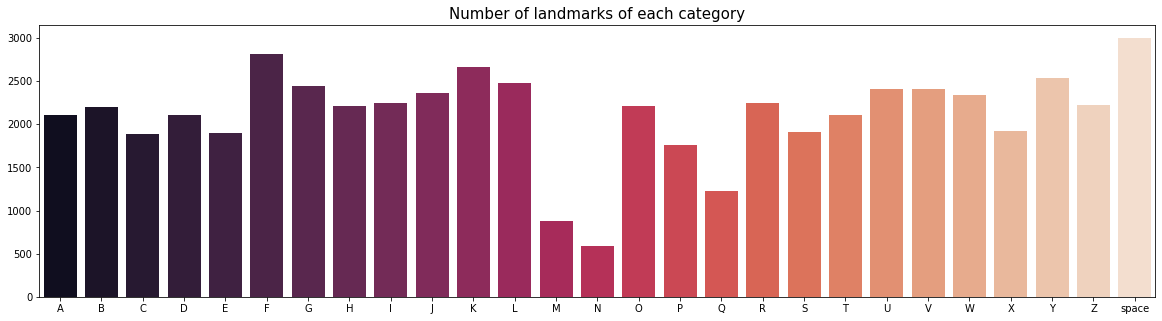

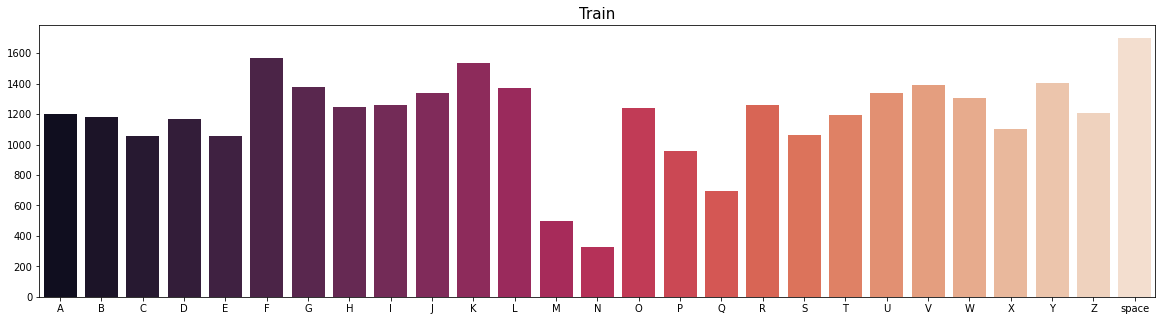

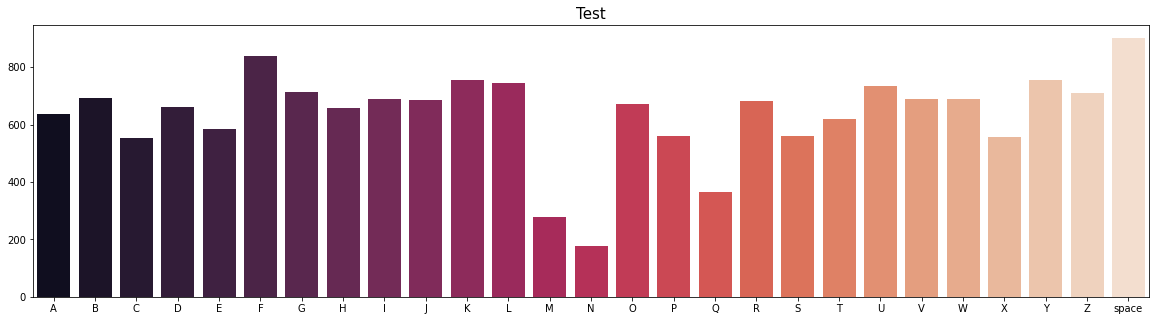

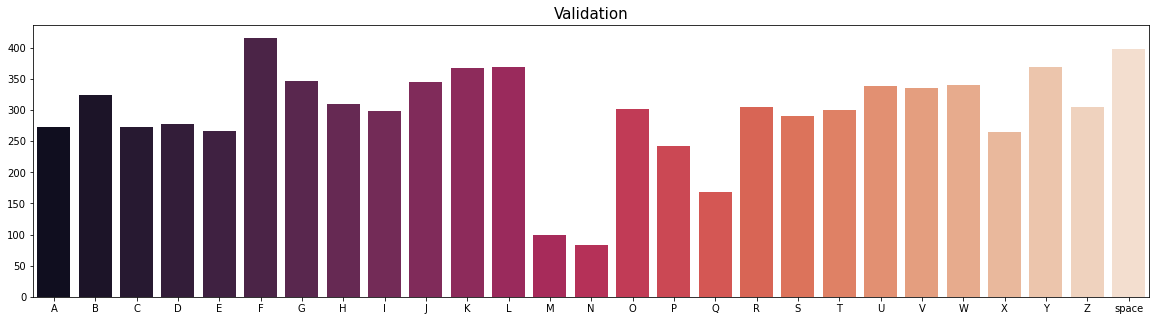

In [ ]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'space']

def barplot(y, s):
  vc = np.sum(y, 0)
  pyplot.figure(figsize=(20, 5))
  sns.barplot(x=labels, y=vc, palette="rocket")
  pyplot.title(s, fontsize=15)
  pyplot.show()

files = ['landmarks_x.txt', 'landmarks_y.txt']
x = list()
for file in files:
    data = read_csv('drive/MyDrive/Gestures/' + file, header=None, delim_whitespace=True).values
    x.append(data)

x = np.dstack(x)

y = to_categorical(read_csv('drive/MyDrive/Gestures/labels.txt', header=None, delim_whitespace=True).values)
barplot(y, "Number of landmarks of each category")

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=0.7, 
                                                    random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                    train_size=0.8, 
                                                    random_state=42)
barplot(y_train, "Train")
barplot(y_test, "Test")
barplot(y_val, "Validation")

Сначала попробуем предсказать данные на простой RNN. Подготавливаем функцию создания модели и, используя тюнер, подбираем параметры.

In [ ]:
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]

def build_modelRNN(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'elu', 'selu'])

    k = hp.Int('num_srnn', 0, 2)
    if k == 0:
      model.add(SimpleRNN(hp.Int('srnn1', min_value=32, max_value=300,step=32), input_shape=(n_timesteps,n_features)))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
    elif k == 1:
      model.add(SimpleRNN(hp.Int('srnn1', min_value=32, max_value=300,step=32), input_shape=(n_timesteps,n_features), return_sequences=True))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
      model.add(SimpleRNN(hp.Int('srnn2', min_value=32, max_value=300,step=32)))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
    elif k == 2:
      model.add(SimpleRNN(hp.Int('srnn1', min_value=32, max_value=300,step=32), input_shape=(n_timesteps,n_features), return_sequences=True))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
      model.add(SimpleRNN(hp.Int('srnn2', min_value=32, max_value=300,step=32), return_sequences=True))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
      model.add(SimpleRNN(hp.Int('srnn3', min_value=32, max_value=300,step=32)))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))

    for j in range(hp.Int('num_denses', 0, 2)):
        model.add(Dense(units=hp.Int('dense_' + str(j), min_value=128, max_value=800,step=32), activation=activation_choice))
        model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
        
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','rmsprop','SGD']),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
hp3 = HyperParameters()

tuner3 = BayesianOptimization(
    build_modelRNN,
    hyperparameters=hp3,
    objective='val_accuracy',
    max_trials=12,              
    directory='gesture'
    )
tuner3.search_space_summary()

Search space summary
Default search space size: 6
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu'], 'ordered': False}
num_srnn (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
srnn1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 300, 'step': 32, 'sampling': None}
dropout_coef (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
num_denses (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'SGD'], 'ordered': False}


In [ ]:
tuner3.search(x_train,
             y_train,
             validation_data=(x_val, y_val),
             batch_size=hp3.Int('batch_size', min_value=64, max_value=1024, step=32),
             epochs=8,
             callbacks=[EarlyStopping(monitor='val_loss', patience=3,
                            restore_best_weights=True)]
             )

tuner3.results_summary()

Trial 12 Complete [00h 05m 40s]
val_accuracy: 0.9910112619400024

Best val_accuracy So Far: 0.9981273412704468
Total elapsed time: 01h 03m 20s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in gesture/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
activation: relu
num_srnn: 1
srnn1: 64
dropout_coef: 0.05
num_denses: 0
optimizer: adam
batch_size: 1024
srnn2: 224
srnn3: 32
dense_0: 480
dense_1: 128
Score: 0.9981273412704468
Trial summary
Hyperparameters:
activation: selu
num_srnn: 2
srnn1: 32
dropout_coef: 0.05
num_denses: 1
optimizer: adam
batch_size: 1024
srnn2: 32
srnn3: 32
dense_0: 128
Score: 0.9980024695396423
Trial summary
Hyperparameters:
activation: selu
num_srnn: 2
srnn1: 32
dropout_coef: 0.05
num_denses: 0
optimizer: SGD
batch_size: 352
srnn2: 256
srnn3: 192
dense_0: 128
dense_1: 128
Score: 0.9975031018257141
Trial summary
Hyperparameters:
activation: relu
num_srnn: 2
srnn1: 32
dropout_coef: 

Обучаем и сохраняем лучшую модель

In [ ]:
epochs, batch_size = 50, 1024
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
model6 = Sequential()
model6.add(SimpleRNN(64, input_shape=(n_timesteps,n_features), return_sequences=True))
model6.add(Dropout(0.05))
model6.add(SimpleRNN(224))
model6.add(Dropout(0.05))
model6.add(Dense(n_outputs, activation='softmax'))
model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
loss6 = model6.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)], shuffle = True)
_, accuracy = model6.evaluate(x_test, y_test, batch_size=batch_size)
model6.summary()
print('Accuracy: %.5f' % accuracy)

Epoch 1/50
32/32 [==============================] - 5s 98ms/step - loss: 1.3775 - accuracy: 0.6889 - val_loss: 0.3469 - val_accuracy: 0.9596
Epoch 2/50
32/32 [==============================] - 3s 84ms/step - loss: 0.2173 - accuracy: 0.9602 - val_loss: 0.1101 - val_accuracy: 0.9853
Epoch 3/50
32/32 [==============================] - 3s 83ms/step - loss: 0.0858 - accuracy: 0.9865 - val_loss: 0.0617 - val_accuracy: 0.9914
Epoch 4/50
32/32 [==============================] - 3s 85ms/step - loss: 0.0513 - accuracy: 0.9927 - val_loss: 0.0378 - val_accuracy: 0.9955
Epoch 5/50
32/32 [==============================] - 3s 86ms/step - loss: 0.0355 - accuracy: 0.9948 - val_loss: 0.0321 - val_accuracy: 0.9959
Epoch 6/50
32/32 [==============================] - 3s 87ms/step - loss: 0.1345 - accuracy: 0.9692 - val_loss: 0.0492 - val_accuracy: 0.9925
Epoch 7/50
32/32 [==============================] - 3s 86ms/step - loss: 0.0351 - accuracy: 0.9948 - val_loss: 0.0238 - val_accuracy: 0.9966
Epoch 8/50
32

In [ ]:
model6.save('drive/My Drive/gr_rnn01_model')

INFO:tensorflow:Assets written to: drive/My Drive/gr_rnn01_model/assets


Обучаем и сохраняем пять лучших моделей

In [ ]:
models1 = tuner3.get_best_models(num_models=5)
i = 0
for model in models1:
  i = i + 1
  if (i == 1 or i == 2):
    batch_size = 1024
  elif i == 3:
    batch_size = 352
  elif i == 4:
    batch_size = 64
  else:
    batch_size = 256
  model.summary()
  model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], shuffle = True)
  _, accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)
  print()
  model.save('drive/My Drive/gr_rnn' + str(i) + '_model')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 21, 64)            4288      
                                                                 
 dropout (Dropout)           (None, 21, 64)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 224)               64736     
                                                                 
 dropout_1 (Dropout)         (None, 224)               0         
                                                                 
 dense (Dense)               (None, 27)                6075      
                                                                 
Total params: 75,099
Trainable params: 75,099
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 

Ещё один поиск

In [ ]:
tuner3.search(x_train,
             y_train,
             validation_data=(x_val, y_val),
             batch_size=hp3.Int('batch_size', min_value=64, max_value=1024, step=32),
             epochs=8,
             callbacks=[ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=0.001)]
             )

tuner3.results_summary()

Trial 12 Complete [00h 05m 24s]
val_accuracy: 0.9940074682235718

Best val_accuracy So Far: 0.9970037341117859
Total elapsed time: 00h 53m 53s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in gesture/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
activation: selu
num_gru: 0
srnn1: 288
dropout_coef: 0.35000000000000003
num_denses: 1
optimizer: adam
batch_size: 736
srnn2: 288
dense_0: 128
srnn3: 32
Score: 0.9970037341117859
Trial summary
Hyperparameters:
activation: elu
num_gru: 1
srnn1: 224
dropout_coef: 0.6500000000000001
num_denses: 0
optimizer: adam
batch_size: 64
srnn2: 128
dense_0: 224
Score: 0.9961298108100891
Trial summary
Hyperparameters:
activation: relu
num_gru: 1
srnn1: 288
dropout_coef: 0.05
num_denses: 0
optimizer: adam
batch_size: 1024
srnn2: 256
dense_0: 512
srnn3: 64
dense_1: 128
Score: 0.9960049986839294
Trial summary
Hyperparameters:
activation: elu
num_gru: 1
srnn1: 160
dropout_coe

Обучаем лучшую модель, тестируем и сохраняем.

In [ ]:
epochs, batch_size = 15, 736
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
model6 = Sequential()
model6.add(SimpleRNN(288, input_shape=(n_timesteps,n_features)))
model6.add(Dropout(0.35))
model6.add(Dense(128, activation='selu'))
model6.add(Dropout(0.35))
model6.add(Dense(n_outputs, activation='softmax'))
model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
loss6 = model6.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.2, min_lr=0.001)])
_, accuracy = model6.evaluate(x_test, y_test, batch_size=batch_size)
model6.summary()
print('Accuracy: %.5f' % accuracy)

Epoch 1/15
44/44 [==============================] - 6s 82ms/step - loss: 1.4429 - accuracy: 0.5839 - val_loss: 0.3372 - val_accuracy: 0.9226 - lr: 0.0010
Epoch 2/15
44/44 [==============================] - 3s 67ms/step - loss: 0.3835 - accuracy: 0.8720 - val_loss: 0.1482 - val_accuracy: 0.9702 - lr: 0.0010
Epoch 3/15
44/44 [==============================] - 3s 65ms/step - loss: 0.2067 - accuracy: 0.9314 - val_loss: 0.1158 - val_accuracy: 0.9655 - lr: 0.0010
Epoch 4/15
44/44 [==============================] - 3s 73ms/step - loss: 0.1515 - accuracy: 0.9516 - val_loss: 0.0803 - val_accuracy: 0.9747 - lr: 0.0010
Epoch 5/15
44/44 [==============================] - 3s 69ms/step - loss: 0.1017 - accuracy: 0.9693 - val_loss: 0.1133 - val_accuracy: 0.9521 - lr: 0.0010
Epoch 6/15
44/44 [==============================] - 3s 68ms/step - loss: 0.0860 - accuracy: 0.9749 - val_loss: 0.0408 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 7/15
44/44 [==============================] - 3s 70ms/step - loss: 0.0

In [ ]:
model6.save('drive/My Drive/gr_rnn_model')

INFO:tensorflow:Assets written to: drive/My Drive/gr_rnn_model/assets


Теперь построим LSTM модель и подберем параметры.

In [ ]:
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]

def build_modelLSTM(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'elu', 'selu'])

    k = hp.Int('num_lstm', 0, 2)
    if k == 0:
      model.add(LSTM(hp.Int('lstm1', min_value=32, max_value=600,step=32), input_shape=(n_timesteps,n_features)))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
    elif k == 1:
      model.add(LSTM(hp.Int('lstm1', min_value=32, max_value=600,step=32), input_shape=(n_timesteps,n_features), return_sequences=True))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
      model.add(LSTM(hp.Int('lstm2', min_value=32, max_value=600,step=32)))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
    elif k == 2:
      model.add(LSTM(hp.Int('lstm1', min_value=32, max_value=600,step=32), input_shape=(n_timesteps,n_features), return_sequences=True))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
      model.add(LSTM(hp.Int('lstm2', min_value=32, max_value=600,step=32), return_sequences=True))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
      model.add(LSTM(hp.Int('lstm3', min_value=32, max_value=600,step=32)))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))

    for j in range(hp.Int('num_denses', 0, 2)):
        model.add(Dense(units=hp.Int('dense_' + str(j), min_value=128, max_value=600,step=32), activation=activation_choice))
        model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
        
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','rmsprop','SGD']),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
hp5 = HyperParameters()

tuner5 = BayesianOptimization(
    build_modelLSTM,
    hyperparameters=hp5,
    objective='val_loss',
    max_trials=12,              
    directory='lstmgr'
    )
tuner5.search_space_summary()

Search space summary
Default search space size: 6
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu'], 'ordered': False}
num_lstm (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
lstm1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 600, 'step': 32, 'sampling': None}
dropout_coef (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
num_denses (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'SGD'], 'ordered': False}


In [ ]:
tuner5.search(x_train,
             y_train,
             validation_data=(x_val, y_val),
             batch_size=hp5.Int('batch_size', min_value=64, max_value=1024, step=32),
             epochs=4,
             callbacks=[ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=0.001)]
             )

tuner5.results_summary()

Trial 12 Complete [00h 01m 08s]
val_loss: 0.12587788701057434

Best val_loss So Far: 0.09142050892114639
Total elapsed time: 00h 14m 31s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in lstmgr/untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
activation: relu
num_lstm: 2
lstm1: 32
dropout_coef: 0.05
num_denses: 0
optimizer: adam
batch_size: 1024
lstm2: 32
dense_0: 128
lstm3: 576
dense_1: 576
Score: 0.09142050892114639
Trial summary
Hyperparameters:
activation: elu
num_lstm: 2
lstm1: 32
dropout_coef: 0.05
num_denses: 2
optimizer: adam
batch_size: 1024
lstm2: 32
dense_0: 128
lstm3: 576
dense_1: 128
Score: 0.0962509959936142
Trial summary
Hyperparameters:
activation: selu
num_lstm: 0
lstm1: 32
dropout_coef: 0.05
num_denses: 2
optimizer: adam
batch_size: 1024
lstm2: 32
dense_0: 128
lstm3: 32
dense_1: 128
Score: 0.11174893379211426
Trial summary
Hyperparameters:
activation: relu
num_lstm: 2
lstm1: 32
dropout_co

Обучаем лучшую модель, проверяем на тестовом множестве и сохраняем.

In [ ]:
epochs, batch_size = 100, 1024
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
model9 = Sequential()
model9.add(LSTM(32, input_shape=(n_timesteps,n_features), return_sequences=True))
model9.add(Dropout(0.05))
model9.add(LSTM(32, return_sequences=True))
model9.add(Dropout(0.05))
model9.add(LSTM(576))
model9.add(Dropout(0.05))
model9.add(Dense(128, activation='relu'))
model9.add(Dropout(0.05))
model9.add(Dense(n_outputs, activation='softmax'))
model9.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
loss9 = model9.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[ReduceLROnPlateau(monitor='val_accuracy', patience=4, factor=0.2, min_lr=0.001)])
_, accuracy = model9.evaluate(x_test, y_test, batch_size=batch_size)
model9.summary()
print('Accuracy: %.5f' % accuracy)

Epoch 1/100
32/32 [==============================] - 12s 180ms/step - loss: 3.0687 - accuracy: 0.0783 - val_loss: 2.6260 - val_accuracy: 0.1303 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 4s 137ms/step - loss: 2.2943 - accuracy: 0.2362 - val_loss: 2.0127 - val_accuracy: 0.3101 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 4s 138ms/step - loss: 1.6763 - accuracy: 0.4170 - val_loss: 1.3082 - val_accuracy: 0.5581 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 4s 139ms/step - loss: 1.2833 - accuracy: 0.5412 - val_loss: 0.9090 - val_accuracy: 0.6858 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 4s 137ms/step - loss: 0.9594 - accuracy: 0.6617 - val_loss: 0.6590 - val_accuracy: 0.7615 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 4s 138ms/step - loss: 0.6697 - accuracy: 0.7525 - val_loss: 0.5549 - val_accuracy: 0.7933 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 4s 138ms/s

In [ ]:
model9.save('drive/My Drive/gr_lstm1_model')

INFO:tensorflow:Assets written to: drive/My Drive/gr_lstm1_model/assets


INFO:tensorflow:Assets written to: drive/My Drive/gr_lstm1_model/assets


Ещё одна модель LSTM.

In [ ]:
epochs, batch_size = 50, 64
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
model4 = Sequential()
model4.add(LSTM(224, input_shape=(n_timesteps,n_features)))
model4.add(Dropout(0.05))
model4.add(Dense(n_outputs, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
loss4 = model4.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.2, min_lr=0.001)])
_, accuracy = model4.evaluate(x_test, y_test, batch_size=batch_size)
model4.summary()
print('Accuracy: %.5f' % accuracy)

Epoch 1/50
501/501 [==============================] - 12s 18ms/step - loss: 1.5989 - accuracy: 0.4791 - val_loss: 0.8542 - val_accuracy: 0.7052 - lr: 0.0010
Epoch 2/50
501/501 [==============================] - 8s 16ms/step - loss: 0.6792 - accuracy: 0.7622 - val_loss: 0.3399 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 3/50
501/501 [==============================] - 8s 15ms/step - loss: 0.4065 - accuracy: 0.8571 - val_loss: 0.3565 - val_accuracy: 0.8866 - lr: 0.0010
Epoch 4/50
501/501 [==============================] - 8s 15ms/step - loss: 0.2731 - accuracy: 0.9033 - val_loss: 0.2225 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 5/50
501/501 [==============================] - 7s 13ms/step - loss: 0.1961 - accuracy: 0.9310 - val_loss: 0.1173 - val_accuracy: 0.9558 - lr: 0.0010
Epoch 6/50
501/501 [==============================] - 6s 13ms/step - loss: 0.1608 - accuracy: 0.9411 - val_loss: 0.2197 - val_accuracy: 0.9191 - lr: 0.0010
Epoch 7/50
501/501 [==============================] - 7s 13ms/s

In [ ]:
model4.save('drive/My Drive/gr_lstm_model')

INFO:tensorflow:Assets written to: drive/My Drive/gr_lstm_model/assets


INFO:tensorflow:Assets written to: drive/My Drive/gr_lstm_model/assets


Строим GRU модель и подбираем параметры.

In [ ]:
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]

def build_modelGRU(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'elu', 'selu'])

    k = hp.Int('num_gru', 0, 2)
    if k == 0:
      model.add(GRU(hp.Int('gru1', min_value=32, max_value=400,step=32), input_shape=(n_timesteps,n_features)))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
    elif k == 1:
      model.add(GRU(hp.Int('gru1', min_value=32, max_value=400,step=32), input_shape=(n_timesteps,n_features), return_sequences=True))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
      model.add(GRU(hp.Int('gru2', min_value=32, max_value=400,step=32)))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
    elif k == 2:
      model.add(GRU(hp.Int('gru1', min_value=32, max_value=400,step=32), input_shape=(n_timesteps,n_features), return_sequences=True))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
      model.add(GRU(hp.Int('gru2', min_value=32, max_value=400,step=32), return_sequences=True))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
      model.add(GRU(hp.Int('gru3', min_value=32, max_value=400,step=32)))
      model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))

    for j in range(hp.Int('num_denses', 0, 2)):
        model.add(Dense(units=hp.Int('dense_' + str(j), min_value=128, max_value=600,step=32), activation=activation_choice))
        model.add(Dropout(hp.Float('dropout_coef', min_value=0.05, max_value=0.9, step=0.1)))
        
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','rmsprop','SGD']),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
hp2 = HyperParameters()

tuner2 = BayesianOptimization(
    build_modelGRU,
    hyperparameters=hp2,
    objective='val_accuracy',
    max_trials=12,              
    directory='grugr'
    )
tuner2.search_space_summary()

Search space summary
Default search space size: 6
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu'], 'ordered': False}
num_gru (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
gru1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 400, 'step': 32, 'sampling': None}
dropout_coef (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
num_denses (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'SGD'], 'ordered': False}


In [ ]:
tuner2.search(x_train,
             y_train,
              validation_data=(x_val, y_val),
             batch_size=hp2.Int('batch_size', min_value=64, max_value=1024, step=32),
             epochs=4,
             callbacks=[ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.2, min_lr=0.001)]
             )

tuner2.results_summary()

Trial 12 Complete [00h 00m 28s]
val_accuracy: 0.9535580277442932

Best val_accuracy So Far: 0.9951310753822327
Total elapsed time: 00h 15m 12s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in grugr/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
activation: relu
num_gru: 1
gru1: 384
dropout_coef: 0.05
num_denses: 0
optimizer: adam
batch_size: 64
gru2: 384
dense_0: 576
dense_1: 128
Score: 0.9951310753822327
Trial summary
Hyperparameters:
activation: elu
num_gru: 1
gru1: 320
dropout_coef: 0.45000000000000007
num_denses: 1
optimizer: adam
batch_size: 544
gru2: 160
dense_0: 288
dense_1: 320
Score: 0.9942571520805359
Trial summary
Hyperparameters:
activation: relu
num_gru: 1
gru1: 384
dropout_coef: 0.8500000000000002
num_denses: 0
optimizer: adam
batch_size: 352
gru2: 320
dense_0: 480
dense_1: 576
Score: 0.9932584166526794
Trial summary
Hyperparameters:
activation: relu
num_gru: 2
gru1: 384
dropout_coef: 0.05
num_denses: 0
optimizer: adam
batch_size: 224
gru2: 384
dense_0: 128
dense_1: 576
gru3: 384
Score: 0.9915106296539307
Trial summary
Hyperparameters:
activation: relu
num_gru: 2

Запускаем полноценное обучение для лучшей модели и проверяем на тестовой выборке.

In [ ]:
epochs, batch_size = 50, 64
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
model5 = Sequential()
model5.add(GRU(384, input_shape=(n_timesteps,n_features), return_sequences=True))
model5.add(Dropout(0.05))
model5.add(GRU(384))
model5.add(Dropout(0.05))
model5.add(Dense(576, activation='relu'))
model5.add(Dropout(0.05))
model5.add(Dense(n_outputs, activation='softmax'))
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
loss5 = model5.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[ReduceLROnPlateau(monitor='val_accuracy', patience=4, factor=0.2, min_lr=0.001)])
_, accuracy = model5.evaluate(x_test, y_test, batch_size=batch_size)
model5.summary()
print('Accuracy: %.5f' % accuracy)

Epoch 1/50
501/501 [==============================] - 23s 25ms/step - loss: 0.6833 - accuracy: 0.7591 - val_loss: 0.2410 - val_accuracy: 0.9235 - lr: 0.0010
Epoch 2/50
501/501 [==============================] - 12s 24ms/step - loss: 0.1338 - accuracy: 0.9537 - val_loss: 0.0522 - val_accuracy: 0.9840 - lr: 0.0010
Epoch 3/50
501/501 [==============================] - 12s 23ms/step - loss: 0.0627 - accuracy: 0.9795 - val_loss: 0.0191 - val_accuracy: 0.9941 - lr: 0.0010
Epoch 4/50
501/501 [==============================] - 12s 23ms/step - loss: 0.0375 - accuracy: 0.9888 - val_loss: 0.0193 - val_accuracy: 0.9939 - lr: 0.0010
Epoch 5/50
501/501 [==============================] - 12s 24ms/step - loss: 0.0328 - accuracy: 0.9898 - val_loss: 0.0268 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 6/50
501/501 [==============================] - 12s 24ms/step - loss: 0.0269 - accuracy: 0.9916 - val_loss: 0.0114 - val_accuracy: 0.9974 - lr: 0.0010
Epoch 7/50
501/501 [==============================] - 12s 

In [ ]:
model5.save('drive/My Drive/gr_gru_model')

INFO:tensorflow:Assets written to: drive/My Drive/gr_gru_model/assets


INFO:tensorflow:Assets written to: drive/My Drive/gr_gru_model/assets


Построим для GRU-модели двунаправленую модель.

In [ ]:
epochs, batch_size = 15, 64
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
model8 = Sequential()
model8.add(Bidirectional(GRU(384, return_sequences=True), input_shape=(n_timesteps,n_features)))
model8.add(Dropout(0.05))
model8.add(Bidirectional(GRU(384)))
model8.add(Dropout(0.05))
model8.add(Dense(576, activation='relu'))
model8.add(Dropout(0.05))
model8.add(Dense(n_outputs, activation='softmax'))
model8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
loss8 = model8.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[ReduceLROnPlateau(monitor='accuracy', patience=4, factor=0.2, min_lr=0.001)])
_, accuracy = model8.evaluate(x_test, y_test, batch_size=batch_size)
model8.summary()
print('Accuracy: %.5f' % accuracy)

Epoch 1/15
501/501 [==============================] - 35s 53ms/step - loss: 0.3695 - accuracy: 0.8735 - val_loss: 0.0371 - val_accuracy: 0.9915 - lr: 0.0010
Epoch 2/15
501/501 [==============================] - 25s 50ms/step - loss: 0.0411 - accuracy: 0.9871 - val_loss: 0.0318 - val_accuracy: 0.9906 - lr: 0.0010
Epoch 3/15
501/501 [==============================] - 25s 50ms/step - loss: 0.0293 - accuracy: 0.9907 - val_loss: 0.0225 - val_accuracy: 0.9920 - lr: 0.0010
Epoch 4/15
501/501 [==============================] - 25s 50ms/step - loss: 0.0232 - accuracy: 0.9935 - val_loss: 0.0490 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 5/15
501/501 [==============================] - 25s 50ms/step - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.0361 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 6/15
501/501 [==============================] - 25s 50ms/step - loss: 0.0132 - accuracy: 0.9962 - val_loss: 0.0099 - val_accuracy: 0.9964 - lr: 0.0010
Epoch 7/15
501/501 [==============================] - 25s 

In [ ]:
model8.save('drive/My Drive/gr_bigru_model')

INFO:tensorflow:Assets written to: drive/My Drive/gr_bigru_model/assets


INFO:tensorflow:Assets written to: drive/My Drive/gr_bigru_model/assets
